# NLP Final Project

## Libaries

In [13]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0, 1, 2, 3, 4"

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from transformers import AutoTokenizer, DataCollatorForSeq2Seq, Trainer, TrainingArguments
import torch

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

2024-12-18 18:14:44.390834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 18:14:44.551105: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-18 18:14:44.551134: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-18 18:14:45.407888: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [2]:
#device = torch.device('cuda:1')

## Data Preperation

In [3]:
import pandas as pd

dataset_dir = '/home/jupyter-mckayqsnell/Lab5-DataExtractionWithTransformers/data/BBC News Summary/News Articles'

In [4]:
def create_bbc_dataframe(dataset_dir):
    texts = []
    categories = []
    titles = []
    filenames = []

    # Loop through each category folder
    for category in os.listdir(dataset_dir):
        category_path = os.path.join(dataset_dir, category)
        if os.path.isdir(category_path):
            # Loop through each file in the category folder
            for filename in os.listdir(category_path):
                file_path = os.path.join(category_path, filename)
                if os.path.isfile(file_path):
                    with open(file_path, 'r', encoding='latin1') as file:
                        text = file.read()
                        # The first line is the title
                        lines = text.strip().split('\n')
                        title = lines[0] if len(lines) > 0 else ''
                        content = '\n'.join(lines[1:]) if len(lines) > 1 else ''
                        titles.append(title)
                        texts.append(content)
                        categories.append(category)
                        filenames.append(filename)
    
    df = pd.DataFrame({
        'Filename': filenames,
        'Title': titles,
        'Content': texts,
        'Category': categories
    })
    
    return df

In [5]:
import os
import pandas as pd

def create_bbc_summary_dataframe(summaries_dir):
    summary_texts = []
    summary_filenames = []
    summary_categories = []
    
    # Loop through each category folder in the summaries directory
    for category in os.listdir(summaries_dir):
        category_path = os.path.join(summaries_dir, category)
        if os.path.isdir(category_path):
            # Loop through each file in the category folder
            for filename in os.listdir(category_path):
                file_path = os.path.join(category_path, filename)
                if os.path.isfile(file_path):
                    with open(file_path, 'r', encoding='latin1') as file:
                        summary = file.read().strip()
                        summary_texts.append(summary)
                        summary_filenames.append(filename)
                        summary_categories.append(category)
    
    # Create a dataframe for summaries
    df_summaries = pd.DataFrame({
        'Filename': summary_filenames,
        'Summary': summary_texts,
        'Category': summary_categories
    })
    
    return df_summaries

In [6]:
df_summaries = create_bbc_summary_dataframe("/home/jupyter-mckayqsnell/Lab5-DataExtractionWithTransformers/data/BBC News Summary/Summaries")

df_summaries.head()

,Filename,Summary,Category
0,350.txt,"US firm Vonage also offers a Voip service, but...",tech
1,384.txt,According to the Financial Times' China corres...,tech
2,381.txt,The base station processes the information fro...,tech
3,174.txt,One of the key issues for keen gadget users is...,tech
4,265.txt,About 53 million people own a mobile in the UK...,tech


In [7]:
bbc_df = create_bbc_dataframe(dataset_dir)

bbc_df.head()

,Filename,Title,Content,Category
0,350.txt,Chip maker backs net phone calls,"\nRich Templeton, the head of giant chip maker...",tech
1,384.txt,China 'ripe' for media explosion,\nAsia is set to drive global media growth to ...,tech
2,381.txt,Kenyan school turns to handhelds,\nAt the Mbita Point primary school in western...,tech
3,174.txt,Gadgets galore on show at fair,\nThe 2005 Consumer Electronics Show in Las Ve...,tech
4,265.txt,Half of UK's mobiles 'go online',\nMultimedia mobile phones are finally showing...,tech


In [8]:
df_merged = pd.merge(
    bbc_df, 
    df_summaries[['Filename', 'Summary', 'Category']], 
    on=['Filename', 'Category'], 
    how='left'
)

In [9]:
df_merged.head()

,Filename,Title,Content,Category,Summary
0,350.txt,Chip maker backs net phone calls,"\nRich Templeton, the head of giant chip maker...",tech,"US firm Vonage also offers a Voip service, but..."
1,384.txt,China 'ripe' for media explosion,\nAsia is set to drive global media growth to ...,tech,According to the Financial Times' China corres...
2,381.txt,Kenyan school turns to handhelds,\nAt the Mbita Point primary school in western...,tech,The base station processes the information fro...
3,174.txt,Gadgets galore on show at fair,\nThe 2005 Consumer Electronics Show in Las Ve...,tech,One of the key issues for keen gadget users is...
4,265.txt,Half of UK's mobiles 'go online',\nMultimedia mobile phones are finally showing...,tech,About 53 million people own a mobile in the UK...


In [10]:
# save df_merged to a csv file
df_merged.to_csv('/home/jupyter-mckayqsnell/FinalProject/df_merged.csv', index=False)

In [11]:
# print the the summary of the first article
print(df_merged['Summary'][0])

US firm Vonage also offers a Voip service, but one which lets people plug an ordinary phone into a broadband router to make calls.Rich Templeton, the head of giant chip maker Texas Instruments, has given his backing to the growing sector of Voice over Internet Telephony (Voip)  Voip allows PC users, and in some cases those with just a broadband connection, to make telephone calls via the net.Subscribers to Wanadoo's broadband service will be able to use the service to make free evening and weekend calls to any UK landline, and free calls at any time to other Wanadoo users.Internet service provider Wanadoo has announced it is launching its own broadband telephony service in the UK.Mr Templeton said Voip would be the next major application to drive broadband connections into homes."Voice-over-packet is going to be the second killer application after broadband internet access," he said.The service will cost an extra Â£4 a month and will come with a free Livebox, the broadband hub which Wa

## Evaluating performance with Summarization since the dataset contains summerizations for each article

BLEU & ROUGE

## Model

In [25]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline


model_name = 'meta-llama/Llama-3.2-1B'

In [26]:
# Load the model and tokenizer only once
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    use_auth_token=True
)

In [27]:
article_text = df_merged["Content"].iloc[0]

In [28]:
# Tokenize the article text
tokens = tokenizer(article_text, return_tensors="pt", truncation=False)

# Count the number of tokens
num_tokens = len(tokens["input_ids"][0])

print(f"Number of tokens: {num_tokens}")

Number of tokens: 588


In [30]:
# how long are the summaries usually?
summary_text = df_merged["Summary"].iloc[0]
# Tokenize the summary text
tokens = tokenizer(summary_text, return_tensors="pt", truncation=False)

# Count the number of tokens
num_tokens = len(tokens["input_ids"][0])

print(f"Number of tokens: {num_tokens}")

Number of tokens: 291


## Method 1: Base Llama model without fine-tuning or context.

Approach: Use the base Llama model to generate summaries without any fine-tuning or additional context.

Prompt: Provide the article text and ask for a summary.

Singleton Initialization:
Instead of re-initializing the pipeline multiple times, set it up once and re-use the same instance. If you need to modify parameters, try passing them during inference calls rather than re-creating the pipeline.

In [31]:
# create the pipeline once
pipe = pipeline(
    "text-generation", 
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
)

In [37]:
def summarize_article(article_text, max_new_tokens=400, temperature=0.7, top_p=0.9):
    prompt = f"Summarize the following article:\n\n{article_text}\n\nSummary:"
    # Specify generation parameters here instead of creating a new pipeline
    output = pipe(prompt, 
                  num_return_sequences=1, 
                  pad_token_id=tokenizer.eos_token_id,
                  max_new_tokens=max_new_tokens,
                  temperature=temperature,
                  top_p=top_p,
                  do_sample=True)
    generated_text = output[0]['generated_text']
    summary_start = generated_text.find("Summary:") + len("Summary:")
    return generated_text[summary_start:].strip()

In [38]:
article_text = df_merged["Content"].iloc[0]

In [39]:
article_text_summary = df_merged["Summary"].iloc[0]

In [40]:
summary = summarize_article(article_text)
print("Generated Summary:", summary)

Generated Summary: Voip will be the next major application to drive broadband connections into homes.

Voip allows PC users, and in some cases those with just a broadband connection, to make telephone calls via the net. Mr Templeton said Voip would be the next major application to drive broadband connections into homes.

Internet service provider Wanadoo has announced it is launching its own broadband telephony service in the UK.

The world's largest maker of chips for mobile phones believes the technology will grow rapidly from the relatively small user base it has currently.

Almost 83 million people have downloaded the software that powers the Skype Voip service, according to the net telephony firm's website.

Skype lets people make free calls to other Skype users and also make low-cost calls to ordinary phone numbers.

US firm Vonage also offers a Voip service, but one which lets people plug an ordinary phone into a broadband router to make calls.

Bill Simmelink, general manager o

In [23]:
from datasets import Dataset
from tqdm.auto import tqdm

ds = Dataset.from_pandas(df_merged)
ds_sampled = ds.shuffle(seed=42).select(range(100))

In [24]:
def generate_summary(example):
    article_text = example["Content"]
    gen_summary = summarize_article(article_text)
    return {"Generated_Summary": gen_summary}

In [25]:
ds_with_summaries = ds_sampled.map(generate_summary, num_proc=1)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


### BLEU and ROUGE SCORES

- ROUGE-1 measures the overlap of individual words (unigrams) between the generated summary and the reference summary
- ROUGE-2 measures the overlap of bigrams (pairs of consecutive words)
- ROUGE-L is based on the longest common subsequence of words between the generated and reference summaries
- BLEU measures how close the generated summary is to the reference summary in terms of overlapping n-grams (up to four-word sequences), and applies a brevity penalty if the generated text is shorter than the reference

In [26]:
import evaluate

def compute_metrics(df):
    """
    Computes ROUGE and BLEU scores for the generated summaries vs. the reference summaries in the given DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing "Summary" and "Generated_Summary" columns.

    Returns:
        (dict, dict): A tuple (rouge_results, bleu_results) where each is a dictionary of metric scores.
    """
    references = df["Summary"].tolist()
    predictions = df["Generated_Summary"].tolist()

    # Load metrics
    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")

    # Compute ROUGE
    rouge_results = rouge.compute(predictions=predictions, references=references)

    # Compute BLEU
    # BLEU expects references as list of lists
    bleu_references = [[ref] for ref in references]
    bleu_results = bleu.compute(predictions=predictions, references=bleu_references)

    return rouge_results, bleu_results

In [28]:
df_with_summaries = ds_with_summaries.to_pandas()
rouge_results, bleu_results = compute_metrics(df_with_summaries)

print("ROUGE Results:", rouge_results)
print("BLEU Result:", bleu_results)

ROUGE Results: {'rouge1': 0.4242405197028268, 'rouge2': 0.27631630983759975, 'rougeL': 0.2593456629567108, 'rougeLsum': 0.2714577838122326}
BLEU Result: {'bleu': 0.28604845216253166, 'precisions': [0.46920649760430055, 0.3150379032731974, 0.27033096926713945, 0.24638887237710277], 'brevity_penalty': 0.9080895389826107, 'length_ratio': 0.9120656576422937, 'translation_length': 17114, 'reference_length': 18764}


In [29]:
df_with_summaries.head()

,Filename,Title,Content,Category,Summary,Generated_Summary
0,165.txt,'Brainwave' cap controls computer,\nA team of US researchers has shown that cont...,tech,Although the two partially-paralysed people pe...,Researchers in the US have used a cap with 64 ...
1,082.txt,Greek duo cleared in doping case,\nSprinters Kostas Kenteris and Katerina Thano...,sport,"Kenteris's lawyer, Gregory Ioannidis, said: ""T...","In the article, Sprinters Kostas Kenteris and ..."
2,399.txt,Farrell saga to drag on - Lindsay,\nWigan chairman Maurice Lindsay says he does ...,sport,Although the move would be a lucrative one for...,Wigan chairman Maurice Lindsay says he does no...
3,256.txt,Blair pledges unity to Labour MPs,\nTony Blair has sought to reassure Labour bac...,politics,Mr Brown allegedly said he could no longer bel...,"Tony Blair and Gordon Brown are at odds, and t..."
4,159.txt,India unveils anti-poverty budget,\nIndia is to boost spending on primary school...,business,But the heavy spending on poverty reduction me...,The Indian government is planning to boost spe...


In [35]:
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

test_sum = [df_with_summaries['Summary'].iloc[0]]
test_gen_sum = [df_with_summaries['Generated_Summary'].iloc[0]]

predictions = test_gen_sum
references = test_sum

rouge_results = rouge.compute(predictions=predictions, references=references)

bleu_references = [[ref] for ref in references]
bleu_results = bleu.compute(predictions=predictions, references=bleu_references)

print("ROUGE Results:", rouge_results)
print("BLEU Result:", bleu_results)

ROUGE Results: {'rouge1': 0.33009708737864074, 'rouge2': 0.15686274509803924, 'rougeL': 0.18446601941747573, 'rougeLsum': 0.18446601941747573}
BLEU Result: {'bleu': 0.008908460132149278, 'precisions': [0.85, 0.38461538461538464, 0.23684210526315788, 0.10810810810810811], 'brevity_penalty': 0.02945180736910728, 'length_ratio': 0.22099447513812154, 'translation_length': 40, 'reference_length': 181}


## Method 3: Fine-tuned Llama model on the BBC dataset, without additional context

Approach: Fine-tune the Llama model on the BBC articles and their summaries.

Prompt: Provide the article text without additional context.

Formatting the Data:

might prepend a special instruction prompt, like:

"Summarize the following article:\n\n{article_text}\n\nSummary:"
and the model’s target is the reference summary text.
Ensure both input and output are tokenized. The model will learn to predict the summary tokens given the article tokens.

70% train
15% validation
15% test

In [17]:
from transformers import DataCollatorForSeq2Seq, Trainer, TrainingArguments

In [18]:
def prepare_examples(examples, max_length=2000, min_summary_length=50):
    articles = examples["Content"]
    summaries = examples["Summary"]
    
    new_examples = {"input_ids": [], "labels": []}
    for article, summary in zip(articles, summaries):
        prompt_text = f"Summarize the following article:\n\n{article}\n\nSummary:"
        prompt_encoding = tokenizer(prompt_text, truncation=False, add_special_tokens=False)
        prompt_ids = prompt_encoding["input_ids"]
        
        summary_encoding = tokenizer(summary, truncation=False, add_special_tokens=False)
        summary_ids = summary_encoding["input_ids"]
        
        total_length = len(prompt_ids) + len(summary_ids)
        
        # If too long, truncate the prompt (article) portion first.
        if total_length > max_length:
            # Try to fit the entire summary if possible
            summary_length_to_fit = len(summary_ids)
            
            # If entire summary doesn't fit, at least fit 'min_summary_length'
            if summary_length_to_fit > (max_length - min_summary_length):
                summary_length_to_fit = min_summary_length
            
            # Max prompt length allowed after reserving space for summary
            max_prompt_length = max_length - summary_length_to_fit
            
            if len(prompt_ids) > max_prompt_length:
                prompt_ids = prompt_ids[:max_prompt_length]
            
            # Re-check total length, if still too long, truncate summary
            if len(prompt_ids) + len(summary_ids) > max_length:
                summary_ids = summary_ids[:max_length - len(prompt_ids)]
        
        full_input_ids = prompt_ids + summary_ids
        
        labels = full_input_ids.copy()
        # Mark the prompt portion as -100
        prompt_length = len(prompt_ids)
        for i in range(prompt_length):
            labels[i] = -100
        
        new_examples["input_ids"].append(full_input_ids)
        new_examples["labels"].append(labels)
    return new_examples

In [19]:
from datasets import Dataset, load_from_disk
dataset = Dataset.from_pandas(df_merged)

In [20]:
dataset = dataset.map(lambda x: prepare_examples(x, max_length=3000, min_summary_length=50), batched=True, remove_columns=dataset.column_names)

Map:   0%|          | 0/2225 [00:00<?, ? examples/s]

In [21]:
# First split: 70% train, 30% test+validation
train_test = dataset.train_test_split(test_size=0.3, seed=42)
train_dataset = train_test['train']
temp_dataset = train_test['test']

# Second split: split the 30% subset into two 15% splits: validation and test
validation_test = temp_dataset.train_test_split(test_size=0.5, seed=42)
validation_dataset = validation_test['train']
test_dataset = validation_test['test']

print("Train size:", len(train_dataset))
print("Validation size:", len(validation_dataset))
print("Test size:", len(test_dataset))

Train size: 1557
Validation size: 334
Test size: 334


In [22]:
print(validation_dataset[300])

{'input_ids': [9370, 5730, 553, 279, 2768, 4652, 25393, 791, 8753, 3109, 374, 311, 1450, 1202, 20558, 13378, 5064, 220, 2031, 76, 33588, 1746, 5925, 76, 8, 304, 12576, 311, 1520, 433, 8209, 16054, 6763, 323, 34446, 927, 23452, 382, 791, 6020, 6462, 374, 20034, 520, 46927, 348, 396, 5079, 304, 6020, 12544, 323, 18899, 1268, 1202, 13378, 374, 61149, 13, 578, 8753, 13378, 5064, 11, 279, 1917, 596, 2132, 7928, 11, 706, 1027, 4295, 555, 43848, 15652, 520, 2162, 323, 279, 7982, 23354, 315, 1561, 4435, 43855, 13, 32926, 29414, 11, 4869, 11, 11922, 279, 1862, 1550, 539, 733, 3117, 3403, 13, 578, 6462, 574, 7376, 555, 30029, 13015, 23286, 2428, 426, 1892, 486, 2933, 1306, 13739, 449, 348, 396, 5079, 6, 24005, 382, 791, 20155, 315, 279, 3300, 482, 922, 220, 1272, 76, 33588, 482, 690, 387, 9076, 304, 279, 1376, 315, 10932, 2335, 17017, 311, 17345, 93998, 24190, 311, 7431, 1124, 311, 594, 8972, 872, 14507, 13, 362, 4726, 220, 868, 76, 33588, 690, 387, 1903, 2561, 311, 13378, 22415, 5983, 11, 902, 

In [23]:
# Data collator (for causal LM, might just use default or Seq2Seq)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, pad_to_multiple_of=8)

In [24]:
training_args = TrainingArguments(
    output_dir="./fine-tuned-llama",
    eval_strategy="steps",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    learning_rate=5e-5,
    num_train_epochs=3,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    fp16=False,
    report_to="none"
)

In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)

In [26]:
trainer.train()

test_results = trainer.evaluate(test_dataset)
print("Test set evaluation:", test_results)

trainer.save_model("fine-tuned-llama-model")

Step,Training Loss,Validation Loss
100,0.438100,0.356885
200,0.311100,0.296605
300,0.293300,0.307655
400,0.291600,0.336056
500,0.285100,0.315621
600,0.277900,0.328738
700,0.258400,0.286617
800,0.259400,0.311707
900,0.378200,0.298660
1000,0.267700,0.284947


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Test set evaluation: {'eval_loss': 0.20476938784122467, 'eval_runtime': 61.4295, 'eval_samples_per_second': 5.437, 'eval_steps_per_second': 5.437, 'epoch': 3.0}


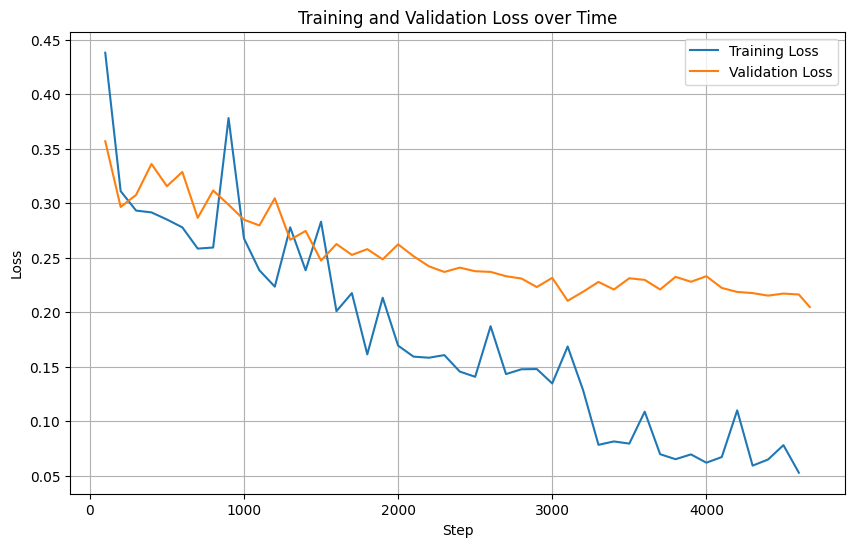

In [27]:
import matplotlib.pyplot as plt

# After training:
history = trainer.state.log_history

# Extract training and validation losses along with steps/epochs
train_steps = []
train_losses = []
eval_steps = []
eval_losses = []

for log in history:
    if "loss" in log and "eval_loss" not in log:
        # This is a training log
        train_steps.append(log["step"] if "step" in log else None)
        train_losses.append(log["loss"])
    elif "eval_loss" in log:
        # This is an evaluation log
        eval_steps.append(log["step"] if "step" in log else None)
        eval_losses.append(log["eval_loss"])

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Time')
plt.legend()
plt.grid(True)
plt.show()

## Testing out the newly finetuned llama model

In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import Dataset
import evaluate
from tqdm.auto import tqdm
import random

# Load the fine-tuned model and tokenizer
model_path = "/home/jupyter-mckayqsnell/FinalProject/fine-tuned-llama-model"  # Path to your fine-tuned model directory
tokenizer = AutoTokenizer.from_pretrained(model_path, use_auth_token=True)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

In [15]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")

In [16]:
def summarize_article_finetuned(article_text, max_new_tokens=400, temperature=0.7, top_p=0.9):
    prompt = f"Summarize the following article:\n\n{article_text}\n\nSummary:"
    output = pipe(
        prompt,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        do_sample=True
    )
    generated_text = output[0]['generated_text']
    summary_start = generated_text.find("Summary:") + len("Summary:")
    return generated_text[summary_start:].strip()

In [17]:
# Test the model on a few articles manually
articles_to_test = [
    df_merged["Content"].iloc[0],
    df_merged["Content"].iloc[10]
]

In [18]:
for i, article in enumerate(articles_to_test):
    summary = summarize_article_finetuned(article)
    print(f"Article {i} summary:\n{summary}\n")

Article 0 summary:
"Voice-over broadband is a key trend across Europe and is set to have a dramatic impact on the telecommunications industry, " Eric Abensur, Wanadoo's chief executive told the BBC News website.Rich Templeton, the head of giant chip maker Texas Instruments, has given his backing to the growing sector of Voice over Internet Telephony (Voip)  Voip allows PC users, and in some cases those with just a broadband connection, to make telephone calls via the net."We can help mass-market adoption of Voip," said AOL chief executive Jonathan Miller."We want to communicate freely, effortlessly and economically wherever we are."The service will cost an extra Â£4 a month and will come with a free Livebox, the broadband hub which Wanadoo plans will be used in future to provide video-on-demand and home security services."It's not about the pipe, if you will, or the silicon per se, it's about the application," he said.The world's largest maker of chips for mobile phones believes the te

In [19]:
# Now let's compute metrics (ROUGE and BLEU) on a random sample of 100 articles from df_merged
def generate_summaries_for_df(df, generate_summary_func, sample_size=100):
    # Take a random sample of the dataframe
    df_sampled = df.sample(n=sample_size, random_state=42).copy().reset_index(drop=True)

    generated_summaries = []
    for i in tqdm(range(len(df_sampled)), desc="Generating summaries"):
        article_text = df_sampled["Content"].iloc[i]
        gen_summary = generate_summary_func(article_text)
        generated_summaries.append(gen_summary)

    df_sampled["Generated_Summary"] = generated_summaries
    return df_sampled

In [20]:
def compute_metrics(df):
    references = df["Summary"].tolist()
    predictions = df["Generated_Summary"].tolist()

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")

    # Compute ROUGE
    rouge_results = rouge.compute(predictions=predictions, references=references)

    # Compute BLEU
    # BLEU expects references as a list of lists
    bleu_references = [[ref] for ref in references]
    bleu_results = bleu.compute(predictions=predictions, references=bleu_references)

    return rouge_results, bleu_results

In [21]:
# Generate summaries on a sample of 100 articles from df_merged using the fine-tuned model
df_with_gen = generate_summaries_for_df(df_merged, summarize_article_finetuned, sample_size=100)

# Compute metrics
rouge_scores, bleu_scores = compute_metrics(df_with_gen)
print("ROUGE results:", rouge_scores)
print("BLEU results:", bleu_scores)

Generating summaries:   0%|          | 0/100 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


ROUGE results: {'rouge1': 0.6074369756164821, 'rouge2': 0.5564532349442375, 'rougeL': 0.47221835638089604, 'rougeLsum': 0.4726310074900368}
BLEU results: {'bleu': 0.4497409349686672, 'precisions': [0.4907514133596795, 0.4492542242280808, 0.435592471990728, 0.42600586640101834], 'brevity_penalty': 1.0, 'length_ratio': 1.7153752000753224, 'translation_length': 36438, 'reference_length': 21242}


In [9]:
df_merged['Content'].iloc[0]

'\nRich Templeton, the head of giant chip maker Texas Instruments, has given his backing to the growing sector of Voice over Internet Telephony (Voip)\n\nVoip allows PC users, and in some cases those with just a broadband connection, to make telephone calls via the net. Mr Templeton said Voip would be the next major application to drive broadband connections into homes. Internet service provider Wanadoo has announced it is launching its own broadband telephony service in the UK.\n\nSubscribers to Wanadoo\'s broadband service will be able to use the service to make free evening and weekend calls to any UK landline, and free calls at any time to other Wanadoo users. The service will cost an extra Â£4 a month and will come with a free Livebox, the broadband hub which Wanadoo plans will be used in future to provide video-on-demand and home security services. The secondary phone line will mean customers can have an extra home phone number and will also provide wireless internet access aroun